<a href="https://colab.research.google.com/github/kjmobile/B735/blob/main/6_Digit_Recognition_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CNN-based MNIST Digit Classification in PyTorch

This notebook builds and trains a Convolutional Neural Network (CNN) using PyTorch to classify handwritten digits from the MNIST dataset. It includes loading and preprocessing the data, constructing the CNN model, training and evaluating it, and visualizing results. The notebook is compatible with both CPU and GPU environments.

### Importing required libraries

This cell imports PyTorch, NumPy, tqdm for progress bars, and `torch.nn` for model components. These are fundamental dependencies for model definition and training.

In [35]:
import torch
import numpy as np
from tqdm.auto import tqdm
import torch.nn as nn
from tqdm import tqdm
import random
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Preparing the MNIST dataset

Here we load the MNIST dataset using `torchvision.datasets.MNIST`, split it into training and validation sets, and apply basic transformations like converting to tensor. The test set is also loaded separately.

##### Loading and preprocessing the data

In [36]:
import torchvision
from torchvision import transforms
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=False,
                                           transform=transform,
                                           download=False)

### Creating DataLoaders

The DataLoader objects are created for batching and shuffling the training data, and for iterating over validation data. This enables efficient training and evaluation.

#### Configuring CNN layers in PyTorch

 * **Conv2d:** `torch.nn.Conv2d`
   * `out_channels`
   * `kernel_size`
   * `stride`
   * `padding`
   
   
 * **MaxPool2d:** `torch.nn.MaxPool2d`
   * `kernel_size`
   * `stride`
   * `padding`
   
   
 * **Dropout** `torch.nn.Dropout`
   * `p`

In [37]:
from torch.utils.data import DataLoader


batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

### Building a CNN architecture

We use `nn.Sequential()` to build a CNN with two convolutional layers followed by ReLU and MaxPool operations. This forms the feature extraction part of the network.

In [38]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

### Flattening convolutional output

After the convolution and pooling layers, the output tensor is flattened to prepare it for fully connected layers.

In [39]:
model.add_module('flatten', nn.Flatten())

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

### Adding fully connected layers and dropout

Two linear layers are added to map the flattened features to class scores, with ReLU activation and dropout for regularization.

In [40]:
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))

model.add_module('fc2', nn.Linear(1024, 10))

### Moving model to the appropriate device

The model is moved to GPU if available, otherwise local CPU.<br>
This ensures compatibility and takes advantage of hardware acceleration when possible.<br>
But you will need to use GPU () and RAM excelleration using Colab to train the 20 echoes within reasonable time.

In [41]:
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
else:
    print("CUDA is not available. Using CPU.")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


CUDA is available. Using GPU.


### Defining the training function

The `train()` function performs training and validation for multiple epochs. It logs loss and accuracy per epoch using `tqdm` for progress visualization.

In [42]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (x_batch, y_batch) in enumerate(tqdm(train_dl, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


### Setting loss function, optimizer, and training

We define `CrossEntropyLoss` and Adam optimizer. The training loop is then initiated for the specified number of epochs using the prepared DataLoaders.

In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

torch.manual_seed(1)
num_epochs = 20 # Reduce this epoch to 2 or 3 if you are using local computer and not using GPU or Colab TPU
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1/20 [Train]: 100%|██████████| 782/782 [00:08<00:00, 96.75it/s]


Epoch 1 accuracy: 0.9505 val_accuracy: 0.9813


Epoch 2/20 [Train]: 100%|██████████| 782/782 [00:08<00:00, 97.43it/s]


Epoch 2 accuracy: 0.9844 val_accuracy: 0.9862


Epoch 3/20 [Train]: 100%|██████████| 782/782 [00:08<00:00, 96.94it/s]


Epoch 3 accuracy: 0.9892 val_accuracy: 0.9863


Epoch 4/20 [Train]: 100%|██████████| 782/782 [00:08<00:00, 96.41it/s]


Epoch 4 accuracy: 0.9922 val_accuracy: 0.9887


Epoch 5/20 [Train]: 100%|██████████| 782/782 [00:08<00:00, 97.28it/s]


Epoch 5 accuracy: 0.9933 val_accuracy: 0.9886


Epoch 6/20 [Train]: 100%|██████████| 782/782 [00:07<00:00, 98.26it/s]


Epoch 6 accuracy: 0.9943 val_accuracy: 0.9899


Epoch 7/20 [Train]: 100%|██████████| 782/782 [00:07<00:00, 97.78it/s]


Epoch 7 accuracy: 0.9954 val_accuracy: 0.9901


Epoch 8/20 [Train]: 100%|██████████| 782/782 [00:07<00:00, 97.88it/s]


Epoch 8 accuracy: 0.9959 val_accuracy: 0.9894


Epoch 9/20 [Train]: 100%|██████████| 782/782 [00:08<00:00, 97.75it/s]


Epoch 9 accuracy: 0.9968 val_accuracy: 0.9916


Epoch 10/20 [Train]: 100%|██████████| 782/782 [00:07<00:00, 98.12it/s]


Epoch 10 accuracy: 0.9965 val_accuracy: 0.9910


Epoch 11/20 [Train]: 100%|██████████| 782/782 [00:07<00:00, 98.30it/s]


Epoch 11 accuracy: 0.9974 val_accuracy: 0.9905


Epoch 12/20 [Train]: 100%|██████████| 782/782 [00:08<00:00, 95.79it/s]


Epoch 12 accuracy: 0.9965 val_accuracy: 0.9912


Epoch 13/20 [Train]: 100%|██████████| 782/782 [00:08<00:00, 96.39it/s]


Epoch 13 accuracy: 0.9976 val_accuracy: 0.9887


Epoch 14/20 [Train]: 100%|██████████| 782/782 [00:08<00:00, 97.60it/s]


Epoch 14 accuracy: 0.9977 val_accuracy: 0.9904


Epoch 15/20 [Train]: 100%|██████████| 782/782 [00:08<00:00, 97.63it/s]


Epoch 15 accuracy: 0.9983 val_accuracy: 0.9911


Epoch 16/20 [Train]: 100%|██████████| 782/782 [00:08<00:00, 96.54it/s]


Epoch 16 accuracy: 0.9976 val_accuracy: 0.9906


Epoch 17/20 [Train]: 100%|██████████| 782/782 [00:08<00:00, 96.51it/s]


Epoch 17 accuracy: 0.9980 val_accuracy: 0.9910


Epoch 18/20 [Train]: 100%|██████████| 782/782 [00:08<00:00, 95.38it/s] 


Epoch 18 accuracy: 0.9978 val_accuracy: 0.9917


Epoch 19/20 [Train]: 100%|██████████| 782/782 [00:07<00:00, 98.58it/s] 


Epoch 19 accuracy: 0.9984 val_accuracy: 0.9905


Epoch 20/20 [Train]: 100%|██████████| 782/782 [00:08<00:00, 96.92it/s]


Epoch 20 accuracy: 0.9983 val_accuracy: 0.9895


### Plotting training and validation performance

Training and validation losses and accuracies across epochs are plotted using matplotlib to visualize model convergence and generalization.

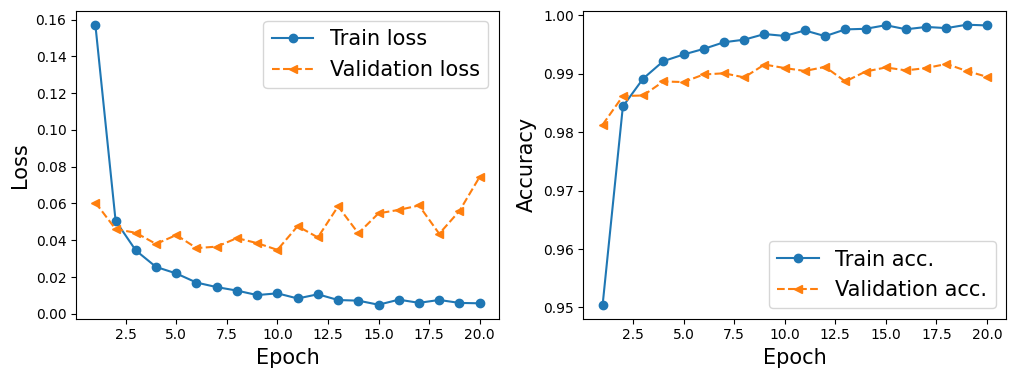

In [44]:
import matplotlib.pyplot as plt


x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

### Evaluating test set accuracy

The trained model is evaluated on the test set. The overall classification accuracy is computed and printed.

In [45]:
model.eval()
with torch.no_grad():
    x_test = mnist_test_dataset.data.unsqueeze(1).float().to(device) / 255.
    y_test = mnist_test_dataset.targets.to(device)
    pred = model(x_test)
    is_correct = (torch.argmax(pred, dim=1) == y_test).float()
    print(f'Test accuracy: {is_correct.mean():.4f}')


Test accuracy: 0.9921


### Visualizing predictions on test images

A few example images from the test set are displayed along with the model's predicted labels. This helps qualitatively assess performance.

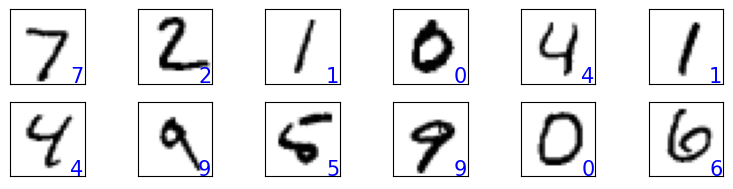

In [46]:
fig = plt.figure(figsize=(8, 2))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]

    img = img.unsqueeze(0).unsqueeze(1).to(device)
    pred_single = model(img)
    y_pred = torch.argmax(pred_single)

    ax.imshow(img.cpu().squeeze(), cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(),
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)

plt.tight_layout()
plt.show()


### Confusion Matrix of Test Predictions

This matrix shows how often the model predicts each digit correctly versus incorrectly.  
It helps identify which digits the model tends to confuse with each other.

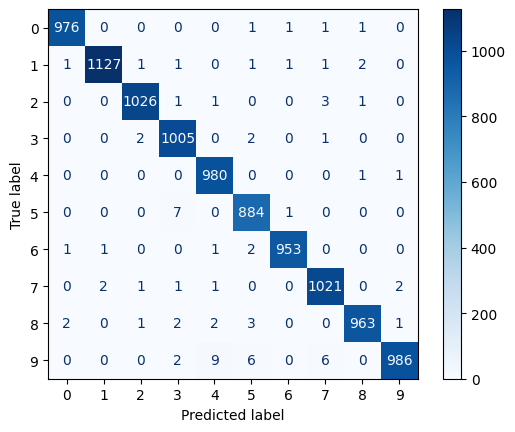

In [47]:
# compute confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = y_test.cpu().numpy()
y_pred = torch.argmax(pred, dim=1).cpu().numpy()

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()


### Per-Class Accuracy

This shows the classification accuracy for each digit from 0 to 9 individually.  
It reveals which digits the model performs best or worst on.

In [48]:
class_accuracy = {}
for i in range(10):
    class_mask = (y_true == i)
    correct = (y_pred[class_mask] == i).sum()
    class_accuracy[i] = correct / class_mask.sum()

for k, v in class_accuracy.items():
    print(f"Digit {k}: {v:.4f}")


Digit 0: 0.9959
Digit 1: 0.9930
Digit 2: 0.9942
Digit 3: 0.9950
Digit 4: 0.9980
Digit 5: 0.9910
Digit 6: 0.9948
Digit 7: 0.9932
Digit 8: 0.9887
Digit 9: 0.9772


### Examples of Misclassified Digits

The following images are incorrectly predicted by the model.  
Each subplot shows the true label and the model’s prediction.

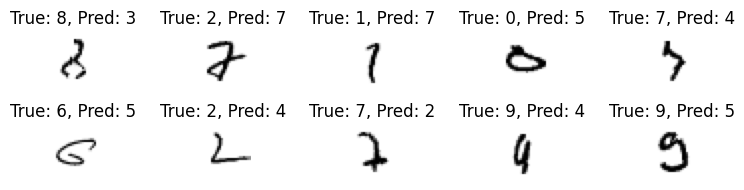

In [49]:
fig = plt.figure(figsize=(8, 2))
wrong = (y_pred != y_true)
wrong_idx = np.where(wrong)[0][:10]  # show first 10 misclassified examples

for i, idx in enumerate(wrong_idx):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(mnist_test_dataset[idx][0][0], cmap='gray_r')
    ax.set_title(f"True: {y_true[idx]}, Pred: {y_pred[idx]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


---

### Saving the trained model: if needed

The final trained model is saved to disk using `torch.save()` so that it can be reused later without retraining.

In [18]:
# import os

# if not os.path.exists('models'):
#     os.mkdir('models')

# path = 'models/mnist-cnn.ph'
# torch.save(model, path)
